In [1]:
# Dependencies
import pandas as pd
import nltk
import re
import datetime as dt
import ipynb
from nltk.corpus import stopwords
from textblob import TextBlob
from matplotlib import pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# If needed, download stopwords corpus from NLTK library
# nltk.download('stopwords')

In [3]:
pd.set_option("display.max_colwidth", -1)

C:\Users\flurp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Basic dataframe cleaning

In [4]:
# Read in geo tagged tweets and corresponding dates
tweets_df = pd.read_csv("../Raw_Data/geo_sentiment.csv")

In [6]:
# Drop Unnamed column
tweets_df = tweets_df.drop(labels="Unnamed: 0", axis=1)

In [7]:
# Convert "created_at" column from dtype object to dtype datetime
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"])

In [8]:
# Rename date column
tweets_df = tweets_df.rename({"created_at": "tweet_date"}, axis=1)

In [9]:
# Validate dtypes
tweets_df.dtypes

id                           int64
coordinates                 object
tweet_date     datetime64[ns, UTC]
text                        object
dtype: object

## Create tweet counts by date and plot

In [13]:
# Create dataframe of counts of tweets per day
tweet_count_df = tweets_df.set_index('tweet_date').groupby(pd.Grouper(freq="D")).count()
# Drop coordinate column
tweet_count_df = tweet_count_df.drop(labels=["coordinates", "id"], axis=1)
# Rename text column
tweet_count_df = tweet_count_df.rename({"text": "tweet count"}, axis=1)

In [14]:
# Find true min number of tweets (disregard first and last days of data collection)
# We can see from the below output that the lowest number of tweets (222) occured on March 29
tweet_count_df.sort_values(by="tweet count").head()

,tweet count
tweet_date,
2020-11-19 00:00:00+00:00,100
2020-03-19 00:00:00+00:00,174
2020-03-29 00:00:00+00:00,222
2020-04-14 00:00:00+00:00,310
2020-10-03 00:00:00+00:00,312


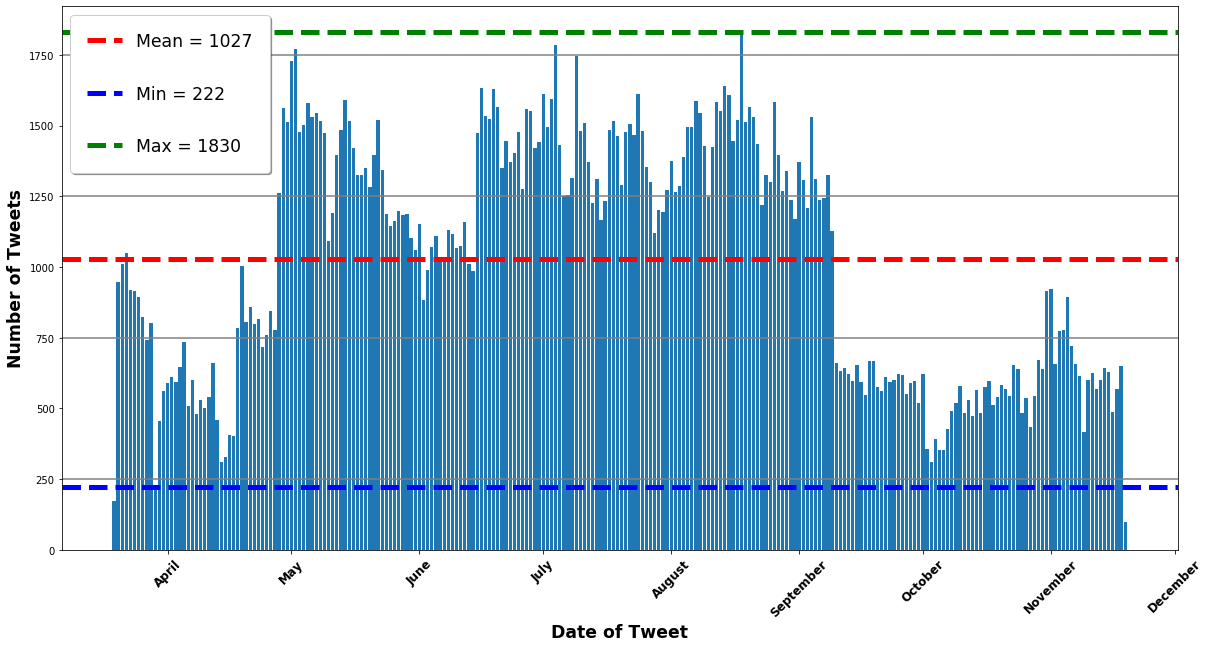

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax= plt.bar(tweet_count_df.index, tweet_count_df["tweet count"])
plt.axhline(y=1750, color="grey")
plt.axhline(y=1250, color="grey")
plt.axhline(y=750, color="grey")
plt.axhline(y=250, color="grey")
line1 = plt.axhline(y=tweet_count_df["tweet count"].mean(), color="red", linestyle="--", linewidth=5)
line2 = plt.axhline(y=tweet_count_df["tweet count"].max(), color="green", linestyle="--", linewidth=5)
line3 = plt.axhline(y=222, color="blue", linestyle="--", linewidth=5)
plt.xlabel("Date of Tweet", fontsize="xx-large", fontweight="black")
plt.ylabel("Number of Tweets", fontsize="xx-large", fontweight="black")
plt.xticks(ticks=[737516., 737546., 737577., 737607., 737638., 737669., 737699.,
                  737730., 737760.], 
           labels=["April", "May", "June", "July", "August", "September",
                   "October", "November", "December"],fontsize="large", rotation=45,
           fontweight="bold")
plt.legend((line1,line3,line2), ("Mean = 1027", "Min = 222", "Max = 1830"), shadow=True,
          labelspacing=2, loc="upper left", borderpad=1, fontsize="xx-large")
plt.savefig("../Images/Tweet_count_per_day.png")
plt.show()

# Sentiment Analysis

## Step 1: Preprocessing

In [ ]:
# NOTE: I have decided to NOT lemmatize verbs, as it is impacting the accuracy of the sentiment score (further research
# required to improve preprocess function to include lemmatization of verbs)

In [16]:
# Convert text column to a list
tweet_list = list(tweets_df["text"])

In [17]:
# Confirm all tweets are included
len(tweet_list)

252718

In [21]:
# Define dictionaries

# Regex patterns
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
user_pattern = r"@[^\s]+"

#POS tags for lemmatization
tag_dict = {"J": 'a', 
            "N": 'n', 
            "V": 'v', 
            "R": 'r'}

# Stop words list (from NLTK corpus)
stopwords_list = stopwords.words("english")

# Thanks to this code: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# Define regex pattern to look for (unicode representation for all emojis)
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

### Define a function that will convert all emojis to words

In [22]:
# Thanks to this dictionary created by NeelShah: https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
# Import unicode emoji to words dictionary
from ipynb.fs.full.Unicode_emojis import UNICODE_EMO

# Begin function
def convert_emojis(text):
    
    # Find all emojis
    emotes = re.findall(emoji_pattern, text)
    
    # Loop through emojis and sub the emoji with literal words using UNICODE_EMO dictionary 
    for emote in emotes:
        try:
            text = re.sub(emote, UNICODE_EMO[emote].replace(":"," ").replace("_"," "), text)
        except KeyError:
            continue 
    
    return text

### Preprocess function

In [25]:
def preprocess(data):
    preprocessed_tweets = []
    # Loop through all tweets
    for tweet in data:
        
        # Replace emojis with words (convert_emojis function defined above)
        tweet = convert_emojis(tweet)
        
        # Remove all urls and usernames
        tweet = re.sub(url_pattern, "", tweet)
        tweet = re.sub(user_pattern, "", tweet)
        
        # Remove all stopwords 
        no_stop_tweet = ""
        for word in tweet.split():
            if word not in stopwords_list:
                no_stop_tweet += (word+" ")
        
        # Create textblob object 
        blob = TextBlob(no_stop_tweet)
        
        # Lemmatize the words in the blob
        # See https://textblob.readthedocs.io/en/dev/quickstart.html#words-inflection-and-lemmatization
        
        # Use only the first letter of the obtained tag (tag[0]) to pass into lemmatize() func
        words_and_tags = [(w, tag_dict.get(tag[0], "n")) for w, tag in blob.tags]
        # Lemmatize according to appropriate POS tag
        # Here we only lemmatize non verbs 
        lemmatized_words_list = [wd.lemmatize(pos) if pos in 
                                 ("a", "n", "r") else wd for wd, pos in words_and_tags]
        
        # join back into a string 
        preprocessed_tweet = " ".join(lemmatized_words_list)
        # Append to list
        preprocessed_tweets.append(preprocessed_tweet)
        
    return preprocessed_tweets
        

In [26]:
import time
t = time.time()
data = preprocess(tweet_list)
print(f"Processing done. Time to complete: {(time.time() - t)} seconds")

Processing done. Time to complete: 1034.6366140842438 seconds


### Sentiment analysis 
#### Method 1: TextBlob's analyzer - see Docs: https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
#### Method 2: vaderSentiment analyzer - see Docs: https://github.com/cjhutto/vaderSentiment

In [27]:
vs = SentimentIntensityAnalyzer()

tweets = []
polarity_list = []
subjectivity_list = []
vader_sentiment_scores = []

for tweet in data:
    # Create textblob object
    blob = TextBlob(tweet)
    # TextBlob analyzer
    sentiment = blob.sentiment
    polarity = sentiment[0]
    subjectivity = sentiment[1]
    
    # vaderSentiment analyzer
    vader_sentiment = vs.polarity_scores(tweet)
    compound = vader_sentiment["compound"]
    
    # Append results to list
    tweets.append(tweet)
    polarity_list.append(polarity)
    subjectivity_list.append(subjectivity)
    vader_sentiment_scores.append(compound)

In [30]:
# Create dataframe with all scores
scores_df = pd.DataFrame({"id": tweets_df["id"], 
                   "tweet_date": tweets_df["tweet_date"],
                   "polarity [-1.0, 1.0]": polarity_list,
                   "subjectivity [0.0, 1.0]": subjectivity_list,
                   "vader sentiment [-1.0, 1.0]": vader_sentiment_scores,
                   "tweets": tweets})

In [32]:
scores_df.head()

,id,tweet_date,"polarity [-1.0, 1.0]","subjectivity [0.0, 1.0]","vader sentiment [-1.0, 1.0]",tweets
0,1248467312014798848,2020-04-10 04:26:17+00:00,0.0000,0.000000,0.1531,At night day Manhattan one sit middle intersec...
1,1248531648351801345,2020-04-10 08:41:56+00:00,0.7000,0.600000,0.9100,If don ’ t want catch body like Corona Virus g...
2,1248549294723997696,2020-04-10 09:52:03+00:00,0.0000,0.000000,0.0000,🇮🇱 Israel crystal ball 10 tear-off calendar 18...
3,1248534172324560896,2020-04-10 08:51:57+00:00,0.0375,0.191667,0.3680,CORONA AWOOF SALE TOKUNBO 2003 CAMRY PRICE 900...
4,1248475333705076739,2020-04-10 04:58:09+00:00,0.0000,0.000000,-0.0516,two week lockdown got like expressionless face...


In [33]:
scores_df = df.set_index(df["tweet_date"])

In [41]:
scores_df = scores_df.set_index(scores_df.index.date)

In [42]:
avg_scores_by_date = scores_df.groupby(scores_df.index).mean()

In [43]:
avg_scores_by_date = avg_scores_by_date.drop(labels="subjectivity [0.0, 1.0]", axis=1)

C:\Users\flurp\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000185D59FC888>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
C:\Users\flurp\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000185D5A0E208>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()


(737490.75, 737760.25)


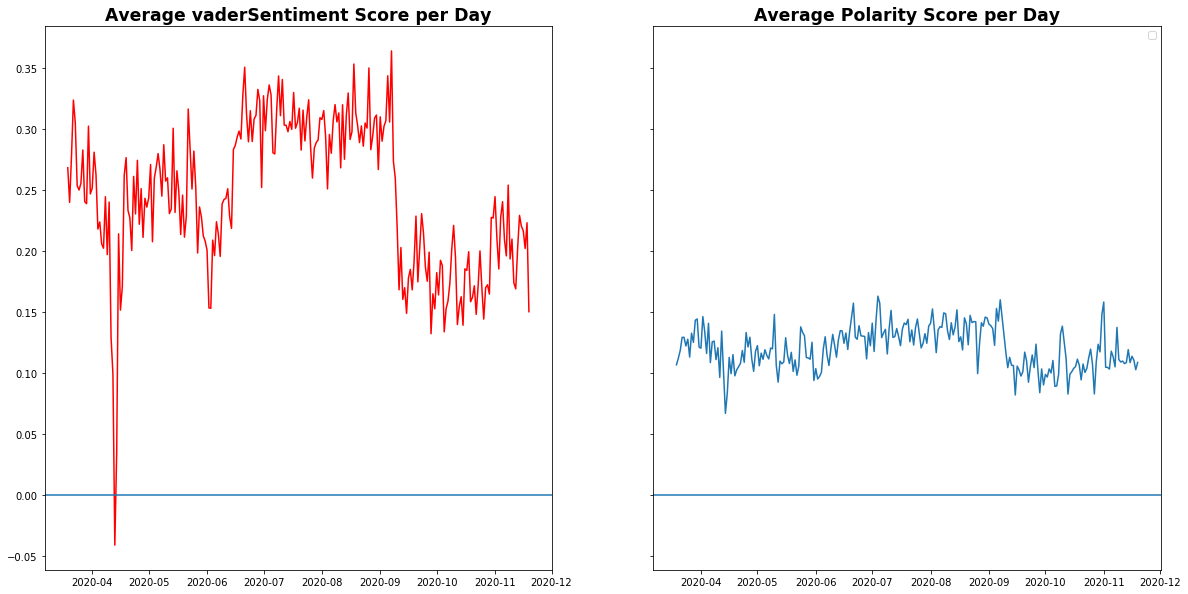

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))

line1 = ax1.plot(avg_scores_by_date.index, avg_scores_by_date["vader sentiment [-1.0, 1.0]"], color="red")
line2 = ax2.plot(avg_scores_by_date.index, avg_scores_by_date["polarity [-1.0, 1.0]"])
ax1.set_title("Average vaderSentiment Score per Day", fontsize="xx-large", fontweight="heavy")
ax2.set_title("Average Polarity Score per Day", fontsize="xx-large", fontweight="heavy")
ax1.axhline(y=0)
ax2.axhline(y=0)
# ax1.hlines(0,737490.75, 737760.25)
# ax2.hlines(0,737477.275, 737773.725 )
plt.legend((line1,line2), ("vaderSentiment", "polarity"))
print(ax2.get_xlim())

In [65]:
# Clean up the master csv with all geo tweet fields and merge with scores_df created above

main_df = pd.read_csv("../Raw_Data/Hydrated/all_geo_tweets.csv")
main_df = main_df.drop(columns=['text','media','urls', 'user_urls', 'user_statuses_count', "user_time_zone", 
                      "user_verified","retweet_id", "retweet_screen_name", "in_reply_to_screen_name", 
                      "in_reply_to_status_id", "in_reply_to_user_id","lang", "possibly_sensitive", 
                      "user_default_profile_image", "user_description", "user_favourites_count",
                      "user_followers_count", "user_listed_count", "user_screen_name.1", "source", "created_at"])

In [66]:
import numpy as np
# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in main_df['coordinates']:
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[1])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[0])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
main_df['latitude'] = lat
main_df['longitude'] = lon

In [67]:
# Number of null coordinate entries vs non-null
main_df["coordinates"].isna().value_counts()

False    252596
True        122
Name: coordinates, dtype: int64

In [72]:
# Merge scores_df and main_df on tweet id
final_df = pd.merge(scores_df, main_df, on="id")

# Export to csv 
final_df.to_csv("../Twitter_Data/final_geo_sentiment_scores.csv")

In [73]:
final_df.head()

,id,tweet_date,"polarity [-1.0, 1.0]","subjectivity [0.0, 1.0]","vader sentiment [-1.0, 1.0]",tweets,coordinates,hashtags,favorite_count,place,retweet_count,tweet_url,user_created_at,user_screen_name,user_friends_count,user_location,user_name,latitude,longitude
0,1248467312014798848,2020-04-10 04:26:17+00:00,0.0000,0.000000,0.1531,At night day Manhattan one sit middle intersec...,"-74.0064,40.7142",follow alone apocalypse corona covid nyc manha...,0,"Manhattan, NY",0,https://twitter.com/EmilChynn/status/124846731...,Thu Jan 29 14:13:54 +0000 2009,EmilChynn,1246,333 Park Avenue South NYC USA,"Emil William Chynn, MD, FACS, MBA",40.7142,-74.0064
1,1248531648351801345,2020-04-10 08:41:56+00:00,0.7000,0.600000,0.9100,If don ’ t want catch body like Corona Virus g...,"36.81666667,-1.28333333",thenewtoronto3,0,"Nairobi, Kenya",0,https://twitter.com/honorabledice/status/12485...,Sat Jan 07 16:13:51 +0000 2017,honorabledice,43,Worldwide,Honorable Dice,-1.28333333,36.81666667
2,1248549294723997696,2020-04-10 09:52:03+00:00,0.0000,0.000000,0.0000,🇮🇱 Israel crystal ball 10 tear-off calendar 18...,"35,31",CovidIsrael,0,Israel,0,https://twitter.com/neilellis/status/124854929...,Thu Apr 03 10:13:37 +0000 2008,neilellis,257,UK,Neil Ellis,31,35
3,1248534172324560896,2020-04-10 08:51:57+00:00,0.0375,0.191667,0.3680,CORONA AWOOF SALE TOKUNBO 2003 CAMRY PRICE 900...,"3.36494044,6.57778852",NaN,1,"Ikeja, Nigeria",0,https://twitter.com/bushman4u2me/status/124853...,Fri Mar 11 00:40:09 +0000 2011,bushman4u2me,826,"Lagos, Nigeria",JUSTICE,6.57778852,3.36494044
4,1248475333705076739,2020-04-10 04:58:09+00:00,0.0000,0.000000,-0.0516,two week lockdown got like expressionless face...,NaN,LockdownSA corona quarantine lockedin rightnow...,0,NaN,0,https://twitter.com/thegearsh/status/124847533...,Fri Jul 10 10:44:22 +0000 2015,thegearsh,1720,Cyberspace,Tech Star,NaN,NaN
